In [1]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
        
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import mlflow
from mlflow.models import infer_signature
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, make_scorer
import shap

In [2]:
df = pd.read_csv("dataframe_final.csv")
df.shape

(356251, 797)

Configuration de mlflow pour qu'il puisse récupèrer nos expérimentations.

In [5]:
# To start the mlflow server in local : mlflow server --host 127.0.0.1 --port 8080

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Projet7_Mean")

<Experiment: artifact_location='mlflow-artifacts:/381266605603233152', creation_time=1707826860654, experiment_id='381266605603233152', last_update_time=1708360234569, lifecycle_stage='active', name='Projet7_Mean', tags={}>

Préparation de notre scorer que nous utiliserons dans nos GridSearchCV.

In [3]:
def custom_score_func(y, y_pred):
    """Fonction de calcul du score métier. Plus le score est faible, meilleur il est. Le résultat est divisé par le nombre total 
    de client en entrée pour qu'il puisse être comparable même lorsqu'un échantillon plus petit est utilisé."""
    cf_matrix = confusion_matrix(y, y_pred)
    FN = cf_matrix[1,0]
    FP = cf_matrix[0,1]

    return (10*FN+FP)/y.shape[0]

In [4]:
custom_scorer = make_scorer(custom_score_func, greater_is_better=False)

In [5]:
scoring = {"AUC": "roc_auc", "CustomScorer": custom_scorer}

Fonctions globales de calcul des métriques, affichage des résultats ou logging des expérimentations vers MLFlow.

In [6]:
def calcul_metrics(model, X, y):
    """Fonction de calcul des metriques précision, AUC et score_metier en fonction du modèle en entrée. Retourne un dictionnaire."""
    metrics = {}
    
    accuracy = model.score(X, y)
    print(f'Précision : {accuracy:.2f}')
    metrics['accuracy'] = accuracy
    
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f'AUC : {roc_auc:.2f}')
    metrics['roc_auc'] = roc_auc

    score_metier = custom_score_func(y, model.predict(X))
    print(f'Score métier : {score_metier}')
    metrics['score_metier'] = score_metier

    return metrics
    

In [7]:
def logToMLflow(model, X, eval_data, metrics, name="", params="", training_tag=""):
    """Fonction de logging d'une expérimentation vers MLFlow."""
    # Start an MLflow run
    with mlflow.start_run(run_name=name):
        # Log the hyperparameters
        if params:
            mlflow.log_params(params)

        # Log the metrics
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("roc_auc", metrics['roc_auc'])
        mlflow.log_metric("score_metier", metrics['score_metier'])
    
        # Set a tag that we can use to remind ourselves what this run was for
        if training_tag:
            mlflow.set_tag("Training Info", training_tag)
    
        # Infer the model signature
        signature = infer_signature(X, model.predict(X))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(model, 'model', signature=signature)

        result = mlflow.evaluate(
            model_info.model_uri,
            eval_data,
            targets="TARGET",
            model_type="classifier",
            evaluators=["default"],
        )

In [8]:
def displayConfMatrix(model, valid_x, valid_y):
    """Fonction d'affichage de la matrice de confusion des résultats d'un modèle."""
    plt.figure(figsize=(12,6))
    cf_matrix = confusion_matrix(valid_y, model.predict(valid_x))
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()

In [9]:
def resultizeGrid(grid):
    """Fonction d'affichage des résultats d'un GridSearch."""
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values('rank_test_CustomScorer')
    
    return res

On divise notre dataframe en train et test en fonction de la présence de l'information dans 'TARGET'.

In [10]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print(f'train_df shape : {train_df.shape}')
print(f'test_df shape : {test_df.shape}')

train_df shape : (307507, 797)
test_df shape : (48744, 797)


Notre X sera toutes les colonnes sauf TARGET et SK_ID_CURR et notre y sera SK_ID_CURR.  
Division du training set en training et validation.

In [11]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR']]

train_x, valid_x, train_y, valid_y = train_test_split(train_df[feats], train_df['TARGET'], test_size=0.15, random_state=0)

Gestion des valeurs manquantes et infinies qui ne sont pas gérées par nos modèles.

In [12]:
col = train_x.columns

train_x.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_x.replace([np.inf, -np.inf], np.nan, inplace=True)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_x = imp.fit_transform(train_x)
valid_x = imp.fit_transform(valid_x)

train_x = pd.DataFrame(train_x, columns=col)
valid_x = pd.DataFrame(valid_x, columns=col)

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)

Découpage en sous-échantillonage simplement car l'exécution de certains modèles prend trop de temps avec le jeu de données entier.

In [13]:
train_x_180k = train_x[:180000]
train_y_180k = train_y[:180000]

train_x_100k = train_x[:100000]
train_y_100k = train_y[:100000]

train_x_30k = train_x[:30000]
train_y_30k = train_y[:30000]

train_x_10k = train_x[:10000]
train_y_10k = train_y[:10000]

Même gestion des valeurs manquantes et infinies pour notre jeu de test (+ exportation pour la suite).

In [14]:
test_feats = [f for f in test_df.columns if f not in ['TARGET']]

test_x = test_df[test_feats]
col = test_x.columns

test_x.replace([np.inf, -np.inf], np.nan, inplace=True)
test_x = imp.fit_transform(test_x)
test_x = pd.DataFrame(test_x, columns=col)

#test_x.to_csv("dataframe_final_test.csv", index=False)

In [16]:
test_x_10k = test_x[:10000]

In [18]:
test_x_10k.to_csv("dataframe_final_test_10k.csv", index=False)

# LOGISTIC REGRESSION

Le modèle logistic regression sera notre base de comparaison. Une classe de 0 indique que le client a bien remboursé sont prêt alors qu'une classe de 1 indique un problème de remboursement du prêt.  
Pour chacun des modèles, nous testerons sans SMOTE puis avec SMOTE et finalement en affinant les hyperparamètres.

## Without SMOTE

Comme on pouvait s'y attendre, sans SMOTE le modèle classe quasiment tous les clients comme ayant rebmoursé le prêt.  
Cela génère forcément une bonne précision (car 92% des clients ont une classe de 0). Cela montre bien qu'ici la précision n'est pas une métrique très pertinente pour nous.  
Par contre on voit un AUC très mauvais à 0.51.  
Notre score métier quant à lui est de 0.795.

Précision : 0.92
AUC : 0.51
Score métier : 0.7945671732391008


2024/02/19 14:57:54 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 14:57:54 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 14:57:55 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 14:57:55 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 14:57:58 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
2024/02/19 14:57:58 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.


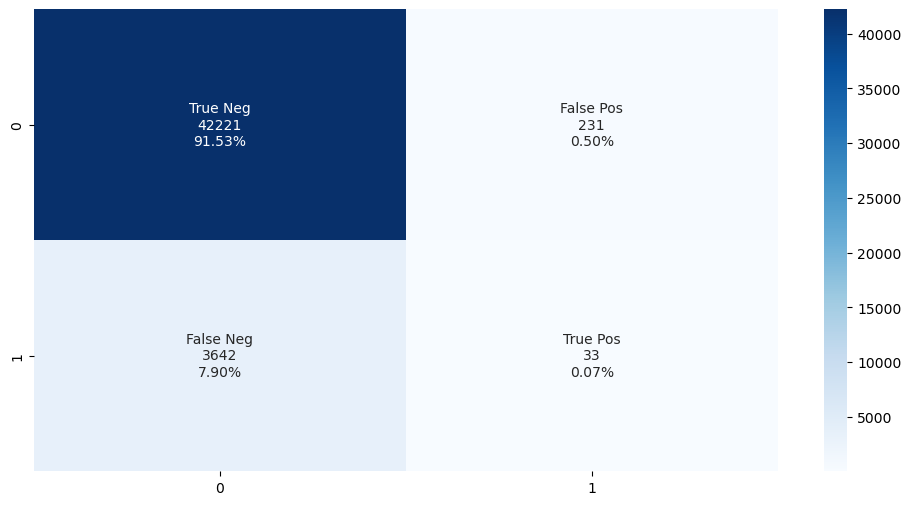

CPU times: total: 22.9 s
Wall time: 27.8 s


In [35]:
%%time

lr = LogisticRegression(random_state=0)
lr.fit(train_x, train_y)

metrics = calcul_metrics(lr, valid_x, valid_y)

logToMLflow(lr, train_x, val_data, metrics, name="LogReg_noSmote_noParam", training_tag="Basic LR model no SMOTE no param")

displayConfMatrix(lr, valid_x, valid_y)

## With SMOTE

SMOTE permet de générer des données de training "artificielles" pour équilibrer les classes. Admettons que nous avons 250000 données de classe 0 et 50000 de classe 1, SMOTE va créer 200000 nouvelles données de classe 1 (en se rapprochant de celles existantes pour les valeurs des variables).  
Ainsi nous avons un problème de classification équilibré.  
Nous utilisons le pipeline de imblearn car cela permet à SMOTE d'être utiliser pour l'entrainement mais par pour la prédiction, ainsi nous ne faussons pas les résultats.

Le résultat est très mauvais mais on voit bien l'utilité de SMOTE ici.

Précision : 0.21
AUC : 0.53
Score métier : 0.8751273657510785


2024/02/19 14:59:26 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 14:59:26 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 14:59:27 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 14:59:27 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 14:59:30 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 14:59:30 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1207!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

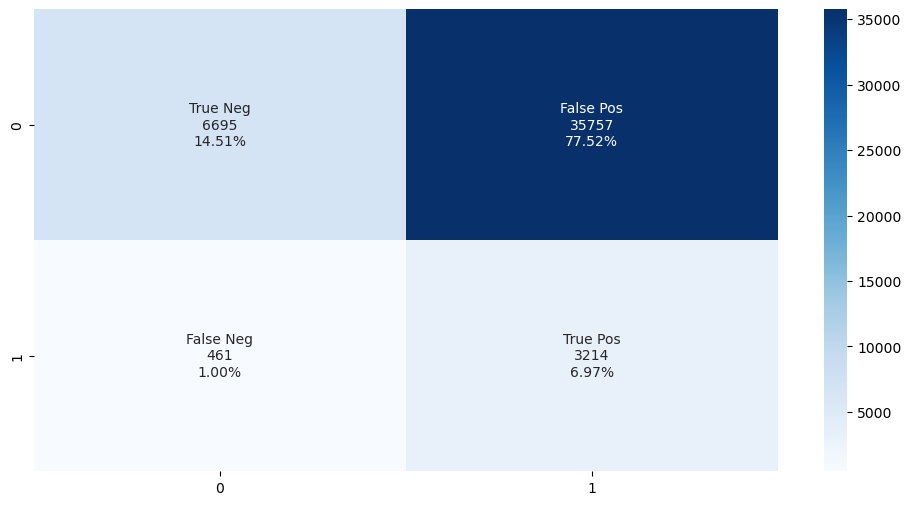

CPU times: total: 52.3 s
Wall time: 1min 1s


In [36]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)


metrics = calcul_metrics(pipeline, valid_x, valid_y)

logToMLflow(pipeline, train_x, val_data, metrics, name="LogReg_Smote_noParam", training_tag="Basic LR model with SMOTE no param")

displayConfMatrix(pipeline, valid_x, valid_y)

# RandomForest

Le deuxième modèle que nous allons tester est RandomForest.

## Paramètres par défaut

### Sans SMOTE

Tout comme pour la logistic régression, sans utiliser SMOTE le modèle prédit presque tous les clients dans la classe 0.

Précision : 0.92
AUC : 0.72
Score métier : 0.7950007587746872


2024/02/23 15:58:48 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/23 15:58:48 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/23 15:58:52 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/23 15:58:55 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/23 15:58:59 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
100%|===================| 3997/4000 [09:11<00:00]        2024/02/23 16:08:10 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ExplainerError('Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of t

<Figure size 1050x700 with 0 Axes>

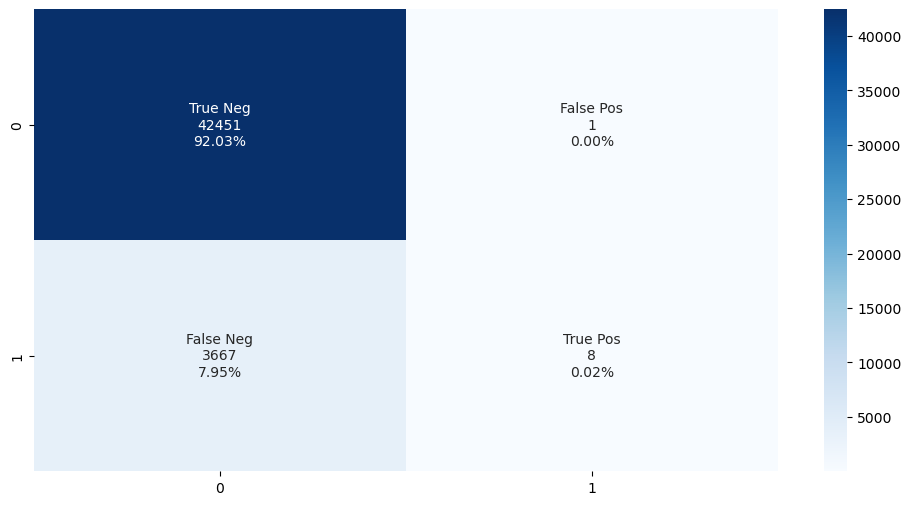

CPU times: total: 14min 33s
Wall time: 16min 28s


In [17]:
%%time

RFC_base = RandomForestClassifier(random_state=0)
RFC_base.fit(train_x, train_y)

metrics = calcul_metrics(RFC_base, valid_x, valid_y)

logToMLflow(RFC_base, train_x, val_data, metrics, name="RndForest_noSmote_noParam", training_tag="RandomForest model no SMOTE no param")
displayConfMatrix(RFC_base, valid_x, valid_y)

### Avec SMOTE

Le résultat ici est toujours assez mauvais mais on voit que grâce à SMOTE, nous avons beaucoup plus de client classé 1, et nous baissons ainsi le nombre de faux négatifs, la valeur que l'on cherche le plus à réduire vu qu'elle est pénalisé 10 fois plus que les faux positifs dans notre score métier.  
Et ce dernier voit donc une amélioration net passant à 0.738, le meilleur score jusque là.

Précision : 0.58
AUC : 0.61
Score métier : 0.7378758644611616


2024/02/23 16:21:17 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/23 16:21:18 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/23 16:21:21 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/23 16:21:24 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/23 16:21:27 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/23 16:21:27 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

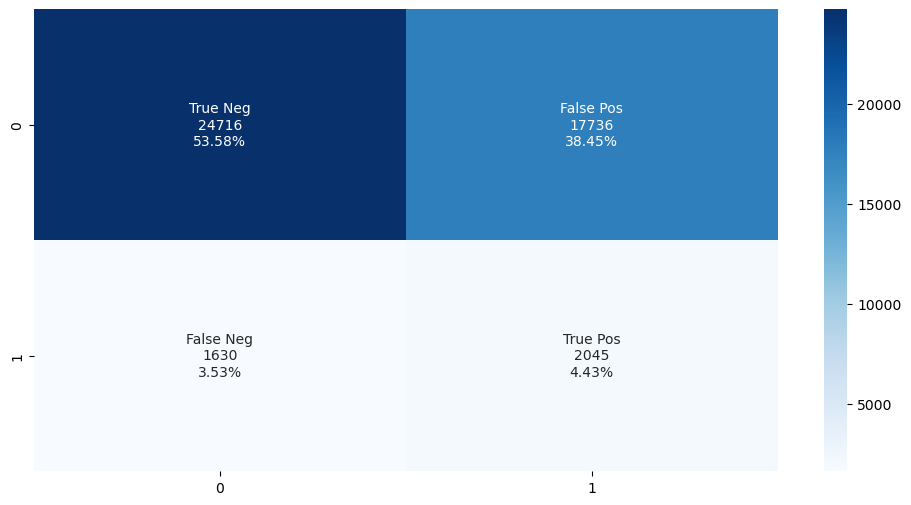

CPU times: total: 9min 47s
Wall time: 12min 6s


In [18]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)

logToMLflow(pipeline, train_x, val_data, metrics, name="RndForest_WithSmote_noParam", training_tag="RandomForest model with SMOTE no param")
displayConfMatrix(pipeline, valid_x, valid_y)

## Recherche des meilleurs hyperparamètres

Pour la recherche des hyperparamètres, nous allons dans un premier temps tenter un RandomizedSearchCV sur de nombreux paramètres et de nombreuses valeurs pour avoir une idée générale de ce qu'on doit optimiser et comment.  
Nous passerons ensuite sur un GridSearchCV pour finir l'optimisation.  
Nous utilisons un scorer spécial crée précédemment grâce au paramètres suivants : scoring=scoring, refit="CustomScorer".  
Le principal problème étant le nombre de données et de variables en entrée. A cela, nous rajoutons SMOTE qui va encore augmenter ce nombre. Je n'ai pas les ressources nécessaires pour faire tourner ces tests là donc nous allons réduire l'échantillon des individus.

In [54]:
rftest = RandomForestClassifier()
print('Liste des paramètres de RandomForestClassifier :\n')
print(rftest.get_params())

Liste des paramètres de RandomForestClassifier :

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Utilisation de RandomizedSearchCV sur un nombre important de paramètres pour avoir une idée globale.

In [63]:
%%time

params = {
    'model__bootstrap': [True, False],
    'model__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10],
    'model__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
    
steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)

rf_random = RandomizedSearchCV(pipeline, params, n_iter = 100, scoring=scoring, refit="CustomScorer", cv = 3, random_state=0)
# Fit the random search model
rf_random.fit(train_x_10k, train_y_10k)

print("Best parameters :",rf_random.best_params_)
print("Score :",rf_random.best_score_)
resultizeGrid(rf_random)

tuned hyperparameters :(best parameters)  {'model__n_estimators': 600, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__bootstrap': True}
accuracy : -0.8165992064113429
CPU times: total: 1min 2s
Wall time: 1h 1min 53s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__bootstrap,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
49,95.684098,1.277924,0.706464,0.033683,600,2,sqrt,10,True,"{'model__n_estimators': 600, 'model__min_sampl...",0.711850,0.021174,17,-0.816599,0.009541,1
16,285.733666,1.999877,2.024920,0.399457,1200,1,sqrt,30,True,"{'model__n_estimators': 1200, 'model__min_samp...",0.710564,0.022846,27,-0.820100,0.002850,2
64,370.663151,3.110898,2.462478,0.019478,1600,1,sqrt,None,True,"{'model__n_estimators': 1600, 'model__min_samp...",0.710262,0.021824,29,-0.820100,0.002850,2
27,373.160966,1.392382,2.473115,0.164365,1600,1,sqrt,80,True,"{'model__n_estimators': 1600, 'model__min_samp...",0.710262,0.021824,29,-0.820100,0.002850,2
39,58.306726,1.330677,0.343327,0.059657,200,4,sqrt,80,False,"{'model__n_estimators': 200, 'model__min_sampl...",0.704633,0.022198,49,-0.820100,0.002850,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.373358,0.026176,0.000000,0.000000,2000,2,auto,40,False,"{'model__n_estimators': 2000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
36,0.396557,0.028497,0.000000,0.000000,1000,1,auto,10,False,"{'model__n_estimators': 1000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
69,0.430621,0.037382,0.000000,0.000000,2000,1,auto,30,False,"{'model__n_estimators': 2000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
56,0.369793,0.018900,0.000000,0.000000,800,4,auto,10,False,"{'model__n_estimators': 800, 'model__min_sampl...",NaN,NaN,53,NaN,NaN,53


Certains paramètres ne semblent pas impacter fortement notre résultat, je les abandonne pour les laisser par défaut et me concentrer sur ceux qui semblent plus importants.  
Je fais maintenant un GridSearchCV pour trouver les paramètres finaux optimaux.

In [18]:
%%time

params = {
    'model__bootstrap': [True],
    'model__max_depth': [10, 20, 30, None],
    'model__max_features': ['sqrt']
}

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_RF = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer")

GS_RF.fit(train_x_30k, train_y_30k)

print("Best parameters :",GS_RF.best_params_)
print("Score :",GS_RF.best_score_)
resultizeGrid(GS_RF)

Best parameters : {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt'}
Score : -0.7766333333333334
CPU times: total: 10min 22s
Wall time: 13min 3s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__max_depth,param_model__max_features,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
0,25.215234,0.274749,0.145925,0.002050,True,10,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.693956,0.010536,4,-0.776633,0.013820,1
1,38.673245,0.329367,0.214399,0.001480,True,20,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.702435,0.005844,1,-0.804400,0.003065,2
3,43.300079,0.375735,0.230703,0.006291,True,None,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.701374,0.004961,3,-0.806667,0.001571,3
2,42.393760,0.491442,0.230204,0.004387,True,30,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.701377,0.003075,2,-0.806800,0.002042,4


Application des meilleurs paramètres sur nos données en validation :  
Les résultats sont meilleurs que précédemment.

Best params : {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt'}
Précision : 0.87
AUC : 0.66
Score métier : 0.6973139376070414


2024/02/19 16:03:54 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 16:03:54 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 16:03:56 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 16:03:57 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 16:04:00 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 16:04:00 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1207!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

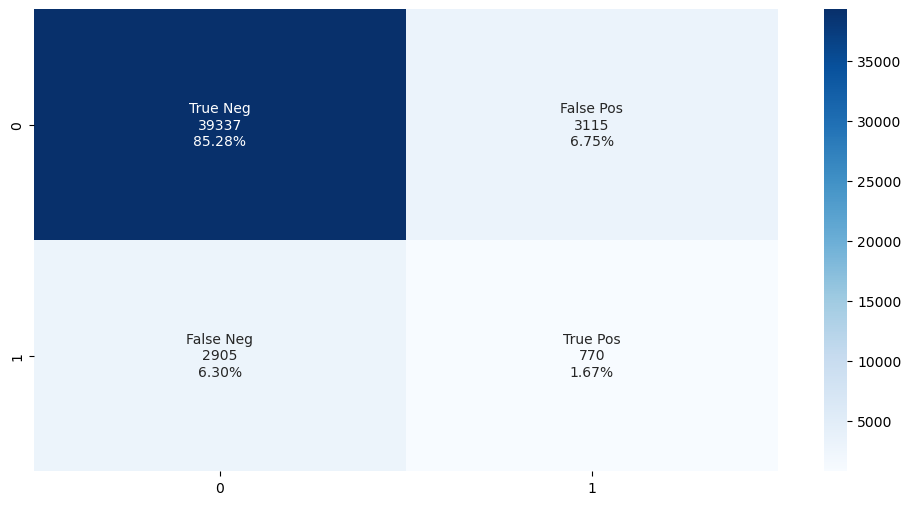

In [19]:
print(f'Best params : {GS_RF.best_params_}')

metrics = calcul_metrics(GS_RF.best_estimator_, valid_x, valid_y)

logToMLflow(GS_RF.best_estimator_, train_x, val_data, metrics, name="RndForest_Smote_GridSearch", params=GS_RF.best_params_, training_tag="RandomForest model with SMOTE")
displayConfMatrix(GS_RF.best_estimator_, valid_x, valid_y)

Test avec un valeur de max_depth encore plus basse :

In [20]:
%%time

params = {
    'model__bootstrap': [True],
    'model__max_depth': [3, 5],
    'model__max_features': ['sqrt']
}

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_RF = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer")

GS_RF.fit(train_x_30k, train_y_30k)

print("Best parameters :",GS_RF.best_params_)
print("Score :",GS_RF.best_score_)
resultizeGrid(GS_RF)

Best parameters : {'model__bootstrap': True, 'model__max_depth': 3, 'model__max_features': 'sqrt'}
Score : -0.6940333333333333
CPU times: total: 1min 42s
Wall time: 2min 5s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__max_depth,param_model__max_features,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
0,8.778446,0.074433,0.091387,0.003789,True,3,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.662454,0.010540,2,-0.694033,0.013565,1
1,13.858106,0.310252,0.100170,0.002063,True,5,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.676469,0.009528,1,-0.718167,0.015943,2


0.671 semble être le meilleur score métier que je peux tirer d'un RandomForest.

Best params : {'model__bootstrap': True, 'model__max_depth': 3, 'model__max_features': 'sqrt'}
Précision : 0.74
AUC : 0.64
Score métier : 0.6707785028291456


2024/02/19 16:07:18 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 16:07:18 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 16:07:19 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 16:07:20 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 16:07:23 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 16:07:23 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1207!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

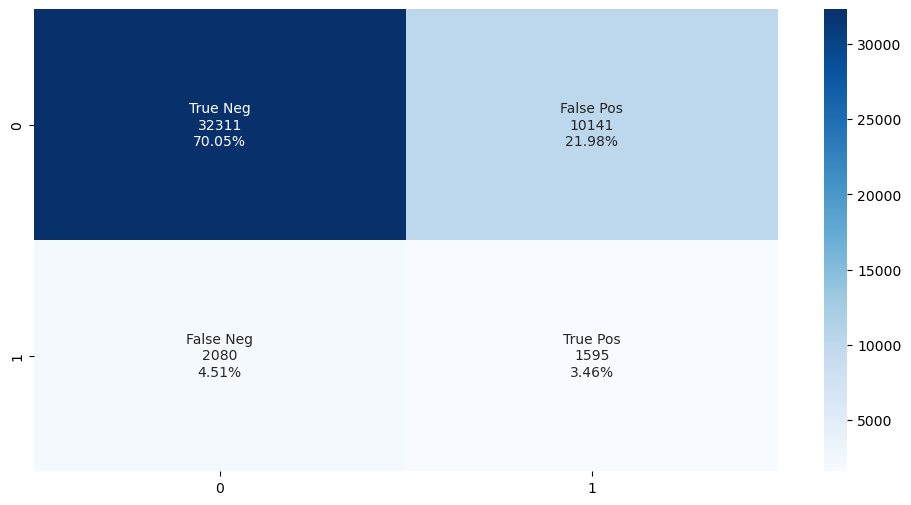

In [21]:
print(f'Best params : {GS_RF.best_params_}')

metrics = calcul_metrics(GS_RF.best_estimator_, valid_x, valid_y)

logToMLflow(GS_RF.best_estimator_, train_x, val_data, metrics, name="RndForest_Smote_GridSearch", params=GS_RF.best_params_, training_tag="RandomForest model with SMOTE")
displayConfMatrix(GS_RF.best_estimator_, valid_x, valid_y)

# LIGHTGBM

## Pramètres par défaut

### Sans SMOTE

Toujours la même conclusion sans utiliser SMOTE.

[LightGBM] [Info] Number of positive: 21150, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.455707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98844
[LightGBM] [Info] Number of data points in the train set: 261380, number of used features: 736
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080917 -> initscore=-2.429957
[LightGBM] [Info] Start training from score -2.429957
Précision : 0.92
AUC : 0.78
Score métier : 0.7827086088408091


2024/02/19 16:10:18 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 16:10:18 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 16:10:19 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 16:10:20 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 16:10:23 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
2024/02/19 16:10:30 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.


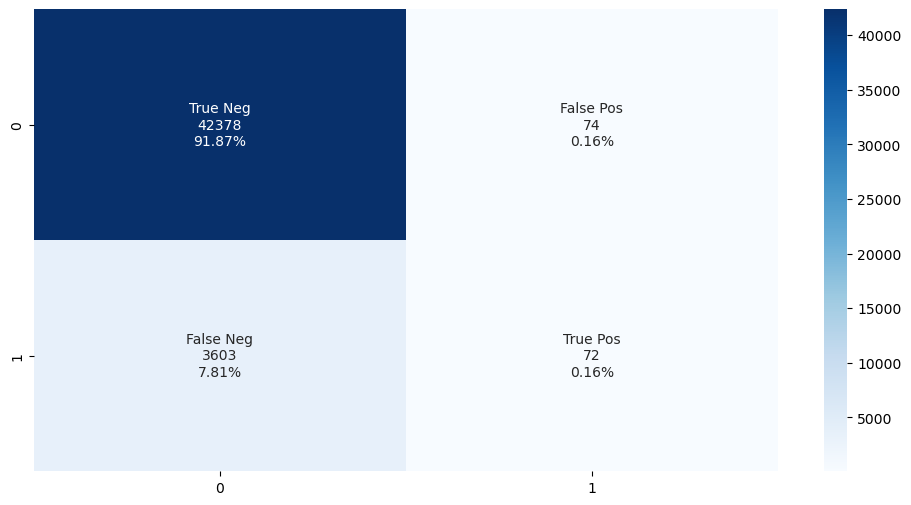

CPU times: total: 43.8 s
Wall time: 34.9 s


In [23]:
%%time

LGBM_base = LGBMClassifier(random_state=0)
LGBM_base.fit(train_x, train_y)

metrics = calcul_metrics(LGBM_base, valid_x, valid_y)

logToMLflow(LGBM_base, train_x, val_data, metrics, name="LGBM_noSmote_noParam", training_tag="LGBM model no SMOTE no param")
displayConfMatrix(LGBM_base, valid_x, valid_y)

### Avec SMOTE

Ici, même sans optimiser les paramètres nous avons déjà un score métier bien meilleur que ce qu'on avait pu voir jusque-là.  
En plus la répartition des classes parait plus "logique" également. Même si nous essayons de minimiser les faux négatifs en priorité, la classe qui doit ressortir le plus reste 0 vis à vis de notre dataset. Les modèles précédents minimisaient les faux négatifs en mettant une grande partie des résultats en 1, ici ce n'est pas le cas.  
Nous allons essayer de continuer à baisser ce score métier de 0.658 en optimisant les paramètres du modèle.

[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.691021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181351
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 764
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Précision : 0.87
AUC : 0.74
Score métier : 0.6578142953151083


2024/02/23 16:47:41 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/23 16:47:41 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/23 16:47:41 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/23 16:47:42 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/23 16:47:45 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/23 16:47:45 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

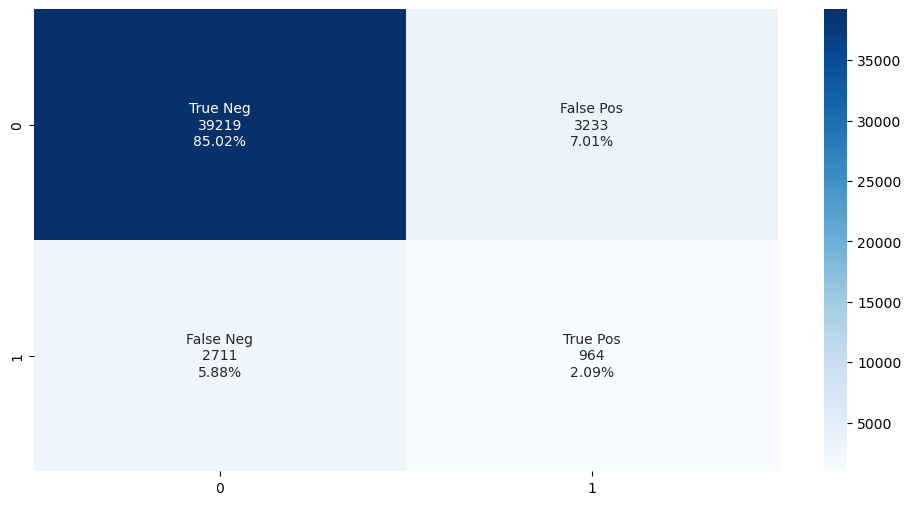

CPU times: total: 3min
Wall time: 1min 9s


In [19]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)

logToMLflow(pipeline, train_x, val_data, metrics, name="LGBM_WithSmote_noParam", training_tag="LGBM model with SMOTE no param")
displayConfMatrix(pipeline, valid_x, valid_y)

## Recherche des meilleurs hyperparamètres

In [30]:
lgbmtest = LGBMClassifier()
print('Liste des paramètres de LGBMClassifier :\n')
print(lgbmtest.get_params())

Liste des paramètres de LGBMClassifier :

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


Je vais commencer par optimiser les paramètres "num_leaves" et "max_depth" qui font partie des plus importants.

In [26]:
%%time

params = {
    'model__num_leaves': [30, 40, 50, 60],
    'model__max_depth': [5, 7, 10, 15, -1]
}
    
steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)

lgbm_random = RandomizedSearchCV(pipeline, params, n_iter = 100, scoring=scoring, refit="CustomScorer", cv = 3, random_state=0)
# Fit the random search model
lgbm_random.fit(train_x_30k, train_y_30k)

print("Best parameters :",lgbm_random.best_params_)
print("Score :",lgbm_random.best_score_)
resultizeGrid(lgbm_random)

[LightGBM] [Info] Number of positive: 18382, number of negative: 18382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154325
[LightGBM] [Info] Number of data points in the train set: 36764, number of used features: 720
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__num_leaves,param_model__n_estimators,param_model__max_depth,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
8,11.955605,0.249320,0.203172,0.005702,30,700,5,"{'model__num_leaves': 30, 'model__n_estimators...",0.736546,0.006769,39,-0.778167,0.003704,1
4,7.722489,0.087522,0.130685,0.007157,30,400,5,"{'model__num_leaves': 30, 'model__n_estimators...",0.746152,0.005201,24,-0.779500,0.002531,2
9,12.225177,0.105152,0.207154,0.002067,40,700,5,"{'model__num_leaves': 40, 'model__n_estimators...",0.737360,0.004368,33,-0.780600,0.003102,3
10,12.451715,0.262855,0.193720,0.002717,50,700,5,"{'model__num_leaves': 50, 'model__n_estimators...",0.737360,0.004368,33,-0.780600,0.003102,3
11,12.472314,0.134022,0.194328,0.002153,60,700,5,"{'model__num_leaves': 60, 'model__n_estimators...",0.737360,0.004368,33,-0.780600,0.003102,3
5,7.961336,0.278781,0.129665,0.003823,40,400,5,"{'model__num_leaves': 40, 'model__n_estimators...",0.747959,0.004592,21,-0.780800,0.001608,6
6,7.938553,0.088950,0.137785,0.015192,50,400,5,"{'model__num_leaves': 50, 'model__n_estimators...",0.747959,0.004592,21,-0.780800,0.001608,6
7,7.972032,0.166792,0.136459,0.005372,60,400,5,"{'model__num_leaves': 60, 'model__n_estimators...",0.747959,0.004592,21,-0.780800,0.001608,6
39,6.348656,0.091469,0.090449,0.013256,60,100,15,"{'model__num_leaves': 60, 'model__n_estimators...",0.753214,0.004166,14,-0.781067,0.002796,9
51,6.167607,0.025830,0.081741,0.003685,60,100,-1,"{'model__num_leaves': 60, 'model__n_estimators...",0.750323,0.003277,18,-0.781267,0.002504,10


In [28]:
%%time

params = {
    'model__num_leaves': [40, 50, 60],
    'model__max_depth': [10, 20, -1]
}

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_LGBM = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer")

GS_LGBM.fit(train_x_100k, train_y_100k)

print("Best parameters :",GS_LGBM.best_params_)
print("Score :",GS_LGBM.best_score_)
resultizeGrid(GS_LGBM)

[LightGBM] [Info] Number of positive: 73529, number of negative: 73529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.460381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172544
[LightGBM] [Info] Number of data points in the train set: 147058, number of used features: 736
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 73529, number of negative: 73529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.464743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170514
[LightGBM] [Info] Number of data points in the train set: 147058, number of used features: 736
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 73530, number of negative: 73530
[LightGBM] [Info] Auto-choosing col-wise mu

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__num_leaves,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
8,17.161208,0.846264,0.174761,0.014938,-1,60,"{'model__max_depth': -1, 'model__num_leaves': 60}",0.764971,0.007077,5,-0.78366,0.001716,1
2,15.482274,0.078420,0.168353,0.006830,10,60,"{'model__max_depth': 10, 'model__num_leaves': 60}",0.764389,0.005695,9,-0.78383,0.002080,2
5,16.458284,0.057079,0.163749,0.005683,20,60,"{'model__max_depth': 20, 'model__num_leaves': 60}",0.764808,0.007144,8,-0.78403,0.000676,3
4,15.566785,0.096846,0.166551,0.008097,20,50,"{'model__max_depth': 20, 'model__num_leaves': 50}",0.765040,0.008392,4,-0.78479,0.002320,4
7,16.234557,0.707893,0.156943,0.009815,-1,50,"{'model__max_depth': -1, 'model__num_leaves': 50}",0.764859,0.008138,7,-0.78504,0.001473,5
1,14.789043,0.146941,0.159546,0.006285,10,50,"{'model__max_depth': 10, 'model__num_leaves': 50}",0.764884,0.004736,6,-0.78568,0.003171,6
3,14.858506,0.702766,0.165551,0.012796,20,40,"{'model__max_depth': 20, 'model__num_leaves': 40}",0.766861,0.005279,1,-0.78643,0.002859,7
6,14.944985,0.521158,0.157743,0.004677,-1,40,"{'model__max_depth': -1, 'model__num_leaves': 40}",0.766680,0.005456,2,-0.78679,0.002716,8
0,14.151736,0.066791,0.162348,0.006280,10,40,"{'model__max_depth': 10, 'model__num_leaves': 40}",0.765660,0.006387,3,-0.78723,0.002228,9


Le résultat n'est pas meilleur que notre test avec les paramètres par défaut.  

Best params : {'model__max_depth': -1, 'model__num_leaves': 60}
Précision : 0.87
AUC : 0.74
Score métier : 0.6614780930908145


2024/02/19 17:29:46 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 17:29:46 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 17:29:46 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 17:29:47 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 17:29:50 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 17:29:50 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

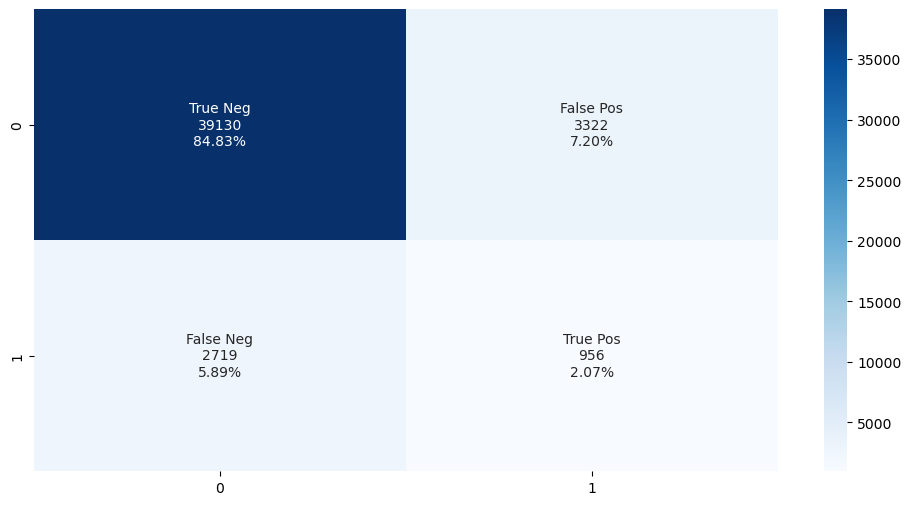

In [34]:
print(f'Best params : {GS_LGBM.best_params_}')

metrics = calcul_metrics(GS_LGBM.best_estimator_, valid_x, valid_y)

logToMLflow(GS_LGBM.best_estimator_, train_x, val_data, metrics, name="LGBM_Smote_GridSearch", params=GS_LGBM.best_params_, training_tag="LightGBM model with SMOTE")
displayConfMatrix(GS_LGBM.best_estimator_, valid_x, valid_y)

# Best Model

Après plusieurs tests sur plusieurs paramètres (dans la limite possible avec mes ressources), voici le meilleur modèle final :

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.713848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181355
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 766
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
Précision : 0.85
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
AUC : 0.75
[LightGBM] [Warning] min_data_in_leaf is set=8,

2024/02/19 18:59:03 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 18:59:03 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


2024/02/19 18:59:05 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


2024/02/19 18:59:06 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 18:59:09 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 18:59:09 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


<Figure size 1050x700 with 0 Axes>

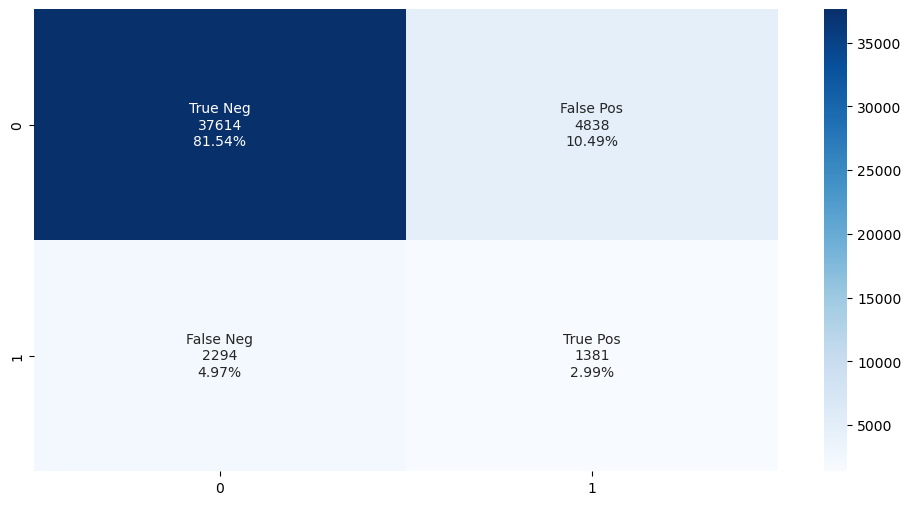

CPU times: total: 5min 36s
Wall time: 2min 16s


In [71]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(num_leaves=65, n_estimators=500, min_data_in_leaf=8, random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)

parameters = {'n_estimators': 500, 'num_leaves': 65, 'min_data_in_leaf': 8}

logToMLflow(pipeline, train_x, val_data, metrics, name="LGBM_Best", params=parameters, training_tag="LGBM Best")
displayConfMatrix(pipeline, valid_x, valid_y)

On obtient un score métier final de 0.602.

## Feature Importances

J'utilise SHAP pour analyser la feature importance de mon modèle.  
Le bar plot permet de voir la feature importance globale, avec notamment les variables EXT_SOURCE_X qui sont très importantes.  
Le waterfall plot permet de voir la feature importance locale pour un individu en particulier. On voit que cet individu n'a aucune des 3 variables EXT_SOURCE_X dans son top 10, cela doit vouloir dire qu'il est dans la moyenne sur ces variables. Pour pour lui c'est la variable AMT_REQ_CREDIT_BUREAU_QRT la plus impactante.

100%|===================| 46091/46127 [10:36<00:00]        

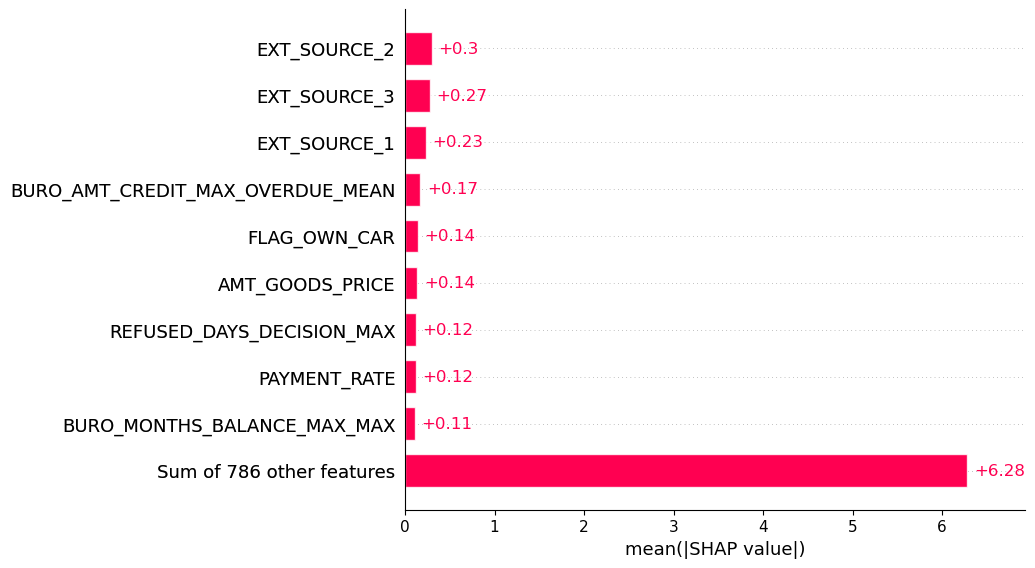

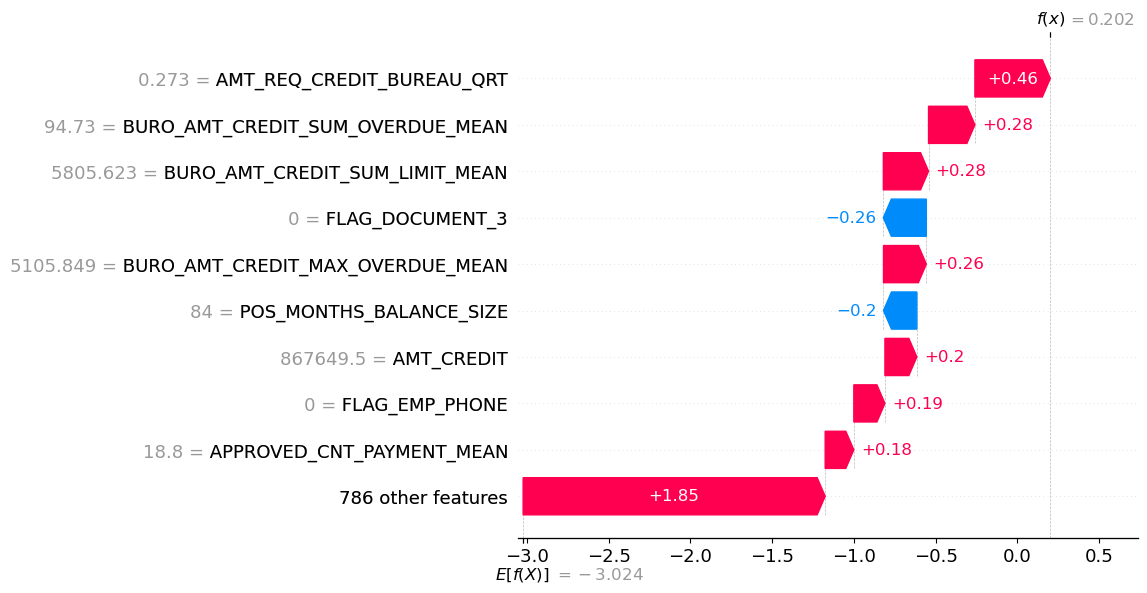

In [67]:
tree_explainer = shap.TreeExplainer(pipeline[1], train_x)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[50])

## Optimisation du threshold

Il reste encore une dernière optimisation possible pour améliorer notre score métier.  
Par défaut, lors d'une classification binaire, le modèle calcule la probabilité que l'individu soit dans la classe 0 ou la classe 1 et l'attribue à la probabilité la plus haute.  
Cependant on peut vouloir modifier ce threshold pour que admettons, si le client a une probabilité de O.35 d'être de classe 1 (donc de ne pas rembourser son prêt) et 0.65 d'être de classe 0 (donc de rembourser son prêt), on le classe quand même en classe 1 car nous avons placé un threshold à 0.3.

Test avec un threshold allant de 0 à 1 avec un pas de 0.5.  
Le meilleur score se situe entre 0.2 et 0.3, et semble êter plus aux alentours de 0.25.

In [20]:
%%time

best_thold = 0.5
best_score = 1

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(num_leaves=65, n_estimators=500, min_data_in_leaf=8, random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

probs = pipeline.predict_proba(valid_x)

for threshold in np.arange(0, 1, 0.05):
    preds = (probs[:,1] >= threshold).astype(int)
    score_metier = custom_score_func(valid_y, preds)
    print(f'Threshold : {threshold}, Score métier : {score_metier}')
    if score_metier < best_score:
        best_score = score_metier
        best_thold = threshold

print(f'Le meilleur score est de {best_score} avec un threshold à {best_thold}')

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.666217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181355
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 766
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
Threshold : 0.0, Score métier : 0.9203286578359746
Threshold : 0.05, Score métier : 0.7176057406724912
Threshold : 0.1, Score métier : 0.6038112168578056
Threshold : 0.15000000000000002, Score mé

Affinons notre test pour aller de 0.2 à 0.3 par pas de 0.01.  
Le meilleur threshold est à 0.24. C'est ce que nous utiliserons.

In [18]:
%%time

best_thold = 0.5
best_score = 1

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(num_leaves=65, n_estimators=500, min_data_in_leaf=8, random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

probs = pipeline.predict_proba(valid_x)

for threshold in np.arange(0.2, 0.3, 0.01):
    preds = (probs[:,1] >= threshold).astype(int)
    score_metier = custom_score_func(valid_y, preds)
    print(f'Threshold : {threshold}, Score métier : {score_metier}')
    if score_metier < best_score:
        best_score = score_metier
        best_thold = threshold

print(f'Le meilleur score est de {best_score} avec un threshold à {best_thold}')

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.704637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181355
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 766
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
Threshold : 0.2, Score métier : 0.5413965790101242
Threshold : 0.21000000000000002, Score métier : 0.5400307845730267
Threshold : 0.22000000000000003, Score métier : 0.5390552171179569
Threshold 

# Préparation des données pour l'API

Je restreint légèrement l'entrainement du modèle à 180000 entrées pour qu'il soit plus léger et que je puisse le pousser sur github.  
Le score baisse légèrement mais reste bon.

In [19]:
steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(num_leaves=65, n_estimators=500, min_data_in_leaf=8, random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x_180k, train_y_180k)

metrics = calcul_metrics(pipeline, valid_x, valid_y)

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Number of positive: 165386, number of negative: 165386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.712884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181587
[LightGBM] [Info] Number of data points in the train set: 330772, number of used features: 764
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
Précision : 0.86
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
AUC : 0.74
[LightGBM] [Warning] min_data_in_leaf is set=8,

In [21]:
X_test_10k = test_x_10k.drop('SK_ID_CURR', axis=1)

In [22]:
tree_explainer = shap.TreeExplainer(pipeline[1])

shap_values = tree_explainer(X_test_10k, check_additivity=False)

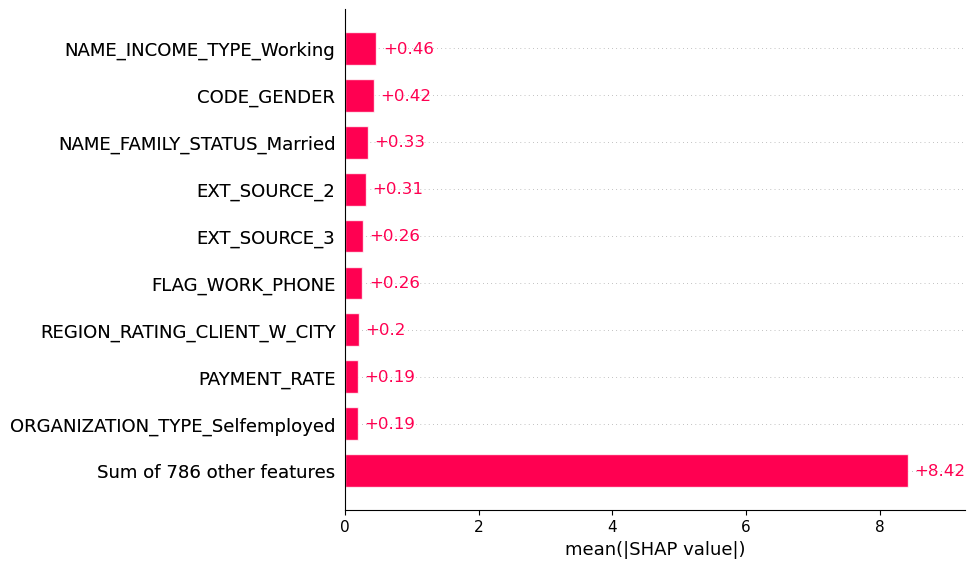

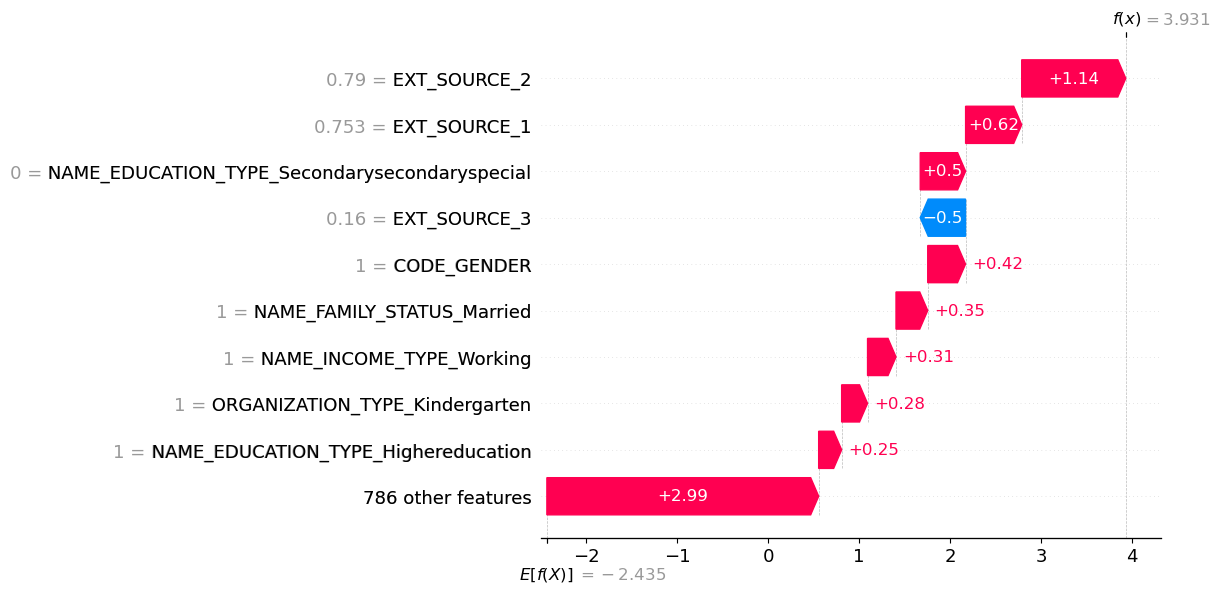

In [23]:
shap.plots.bar(shap_values[:,:,0])
shap.plots.waterfall(shap_values[:,:,0][0])

In [25]:
shap_df = pd.DataFrame(shap_values.values[:, :, 1], columns=X_test_10k.columns)

In [26]:
shap_df_abs = shap_df.abs()
shap_df_abs

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0.415660,0.038775,0.068849,0.050912,0.004958,0.047090,0.042210,0.089336,0.008223,0.053061,...,0.0,0.000025,0.000009,0.000043,0.0,0.0,0.0,0.0,0.0,0.000062
1,0.284359,0.055111,0.052886,0.067248,0.005080,0.114925,0.063579,0.119481,0.051730,0.016227,...,0.0,0.000058,0.000009,0.000019,0.0,0.0,0.0,0.0,0.0,0.000013
2,0.245840,0.491676,0.052019,0.042997,0.006815,0.052311,0.128276,0.024202,0.019591,0.023061,...,0.0,0.000015,0.000013,0.000009,0.0,0.0,0.0,0.0,0.0,0.000246
3,0.546928,0.070282,0.040265,0.087067,0.040996,0.079787,0.146119,0.088401,0.008913,0.023720,...,0.0,0.000024,0.000010,0.000009,0.0,0.0,0.0,0.0,0.0,0.000035
4,0.410422,0.409841,0.078871,0.024117,0.005200,0.015991,0.119112,0.061568,0.050051,0.043424,...,0.0,0.000036,0.000010,0.000014,0.0,0.0,0.0,0.0,0.0,0.000045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.478307,0.056485,0.066466,0.054148,0.001513,0.110701,0.035052,0.022623,0.014252,0.014329,...,0.0,0.000014,0.000014,0.000037,0.0,0.0,0.0,0.0,0.0,0.000058
9996,0.259897,0.242954,0.042847,0.042779,0.005181,0.010285,0.138304,0.113499,0.076550,0.040483,...,0.0,0.000032,0.000007,0.000009,0.0,0.0,0.0,0.0,0.0,0.000007
9997,0.374237,0.054482,0.064194,0.070056,0.025004,0.172128,0.059488,0.020310,0.000976,0.020355,...,0.0,0.000054,0.000010,0.000014,0.0,0.0,0.0,0.0,0.0,0.000046
9998,0.287186,0.061306,0.068088,0.024317,0.003846,0.082483,0.058448,0.089187,0.007963,0.014450,...,0.0,0.000031,0.000013,0.000016,0.0,0.0,0.0,0.0,0.0,0.000060


In [27]:
shapGlobal = shap_df_abs.mean()

In [28]:
shapGlobalSorted = shapGlobal.sort_values(ascending=False)

In [29]:
shapGlobalSorted.to_csv("shapGlobalSorted.csv", index_label=["Features", "Shap Values"])

In [30]:
testShapSor= pd.read_csv("shapGlobalSorted.csv")
testShapSor

,Features,Shap Values
0,NAME_INCOME_TYPE_Working,0.463384
1,CODE_GENDER,0.424042
2,NAME_FAMILY_STATUS_Married,0.333702
3,EXT_SOURCE_2,0.305312
4,EXT_SOURCE_3,0.262465
...,...,...
790,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,0.000000
791,ORGANIZATION_TYPE_Industrytype8,0.000000
792,PREV_CODE_REJECT_REASON_nan_MEAN,0.000000
793,ORGANIZATION_TYPE_Industrytype7,0.000000
